In [ ]:
# 导入必要的函数库
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import serial
import pylab as pl
import scipy.ndimage
import threading
import time
from matplotlib.patches import Polygon
from scipy.signal import convolve2d 
from PIL import Image
from scipy import ndimage

In [ ]:
# 打开摄像头，占用内存大，不轻易运行
# capture=cv2.VideoCapture(1)

In [ ]:
# 打开串口
# ser_32 = serial.Serial('/dev/ttyAMA0', 921600)
# ser_screen=serial.Serial('/dev/ttyAMA3', 115200)

In [ ]:
# 获取并处理图像
def get_image():
    while True:
        # 开全局变量处理，分理处红绿蓝
        global image, image_red, image_green, image_blue
        # 从摄像头获取图像
        # _,image=capture.read()
        image=cv2.imread('1.jpg')
        image_red=image[:,:,2].astype(np.float32)
        image_green=image[:,:,1].astype(np.float32)
        image_blue=image[:,:,0].astype(np.float32)
        #cv2.imshow('image',image)
        #cv2.waitKey(1)

# 获取图像单独开进程
# get_image_threading = threading.Thread(target=get_image)
# get_image_threading.start()

In [ ]:
# 发送命令，通用函数
def send_order(order, ser):
    print('order='+order)
    encoded_order = order.encode()
    ser.write(encoded_order)

In [ ]:
# 获取消息，通用函数
def get_mail(ser):
    encoded_mail = ser.read(1)
    print('mail='+encoded_mail)

In [ ]:
# 突出图像中的红色目标
def get_red():
    global image, image_red, image_green, image_blue
    image_red_only=image_red*2-image_blue-image_green
    image_red_only[image_red_only<0]=0
    return image_red_only

In [ ]:
# 在某一图像的指定位置添加图案
kernel = np.array([
[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
[0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0],
[0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1],
[0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0],
[0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0],
[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0],
[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
[0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
[0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0],
[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
])*255
def draw_image(image_gray_to_draw, kernel, kernel_point):
    try:
        image_gray_to_draw[int(kernel_point[0]-11):int(kernel_point[0]+11),int(kernel_point[1]-11):int(kernel_point[1]+11)]=kernel
    except:
        pass
    return image_gray_to_draw
# 拍照，保存一张照片
def take_photo(photo_name):
    global capture
    photo_name=photo_name+'.jpg'
    _,image=capture.read()
    cv2.imwrite(photo_name,image)
    print('take photo success')
# 展示图片
def show_image(image):
    image_show=image.astype(np.uint8)
    plt.imshow(image_show, cmap='gray')
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [ ]:
# 模式匹配找车
# 这个是目标图像
# aim_image = cv2.imread('aim.png')
# 这个是目标图像的灰度图
# aim_gray = cv2.cvtColor(aim_image, cv2.COLOR_BGR2GRAY)
threshold = 0.8
def find_car_mate(image_gray):
    global car_center
    try:
        result = cv2.matchTemplate(image_gray, aim_gray, cv2.TM_CCOEFF_NORMED)
        locations = np.where(result >= threshold)
        # 转换为(x, y)坐标
        locations = list(zip(*locations[::-1]))
        # 转换为目标中心点坐标
        car_center=np.array([int(locations[0][1] + aim_image.shape[0] / 2),int(locations[0][0] + aim_image.shape[1] / 2)])
    except:
        car_center=car_center
    return(car_center)

In [ ]:
# 颜色识别找车
def find_car_red(image_gray):
    global car_center
    try:
        d1=np.argwhere(image_gray[70:100,100:540] > 100)
        car_center=np.mean(d1,axis=0)
    except:
        car_center=car_center

In [ ]:
# 这里默认从左到右的顺序，从上到下的顺序
grid_1=[]
label_1=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
# 定位函数，定位车在哪个格子里
def locate_car(car_center):
    # 首先找到小车在16宫格内的坐标
    car_center_M=car_center
    car_index=int(car_center_M[0]/120)*4+int(car_center_M[1]/160)
    return label_1[car_index]

In [ ]:
# 我们需要将我们读取到的图像映射成一个平整的图像
ex1=cv2.imread('good.jpg')
ex1_grey=cv2.cvtColor(ex1, cv2.COLOR_BGR2GRAY)
grid=cv2.imread('grid.jpg')
grid_grey=cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)
ad=cv2.imread('grid.jpg')
ad_grey=cv2.cvtColor(ad, cv2.COLOR_BGR2GRAY)

In [ ]:
ad.shape

In [ ]:
968/4

In [ ]:
M=np.load('M.npy')
ex1_grey2=ex1_grey.copy()
# pts0=np.float32([[63,165],[413,116],[413,562],[53,502]])
show_image(draw_image(ex1_grey2, kernel, [253,402]))
a=np.array([402,253,1])
now_position=np.dot(M,a)
print(now_position)

In [ ]:
print(type(M))

In [ ]:
M=np.save('M.npy',M)

In [ ]:
M=np.load('M.npy')

In [ ]:
# 我们需要将我们读取到的图像映射成一个平整的图像
# 对应原先图像的，左上，左下，右下，右上，四个点
pts0=np.float32([[63,165],[413,116],[413,562],[53,502]])
# 建立映射需要的一一对应
pts1=np.float32([[pts0[0][1],pts0[0][0]],[pts0[3][1],pts0[3][0]],[pts0[2][1],pts0[2][0]],[pts0[1][1],pts0[1][0]]])
# 对应映射后图像，左上，左下，右下，右上，四个点
pts2=np.float32([[0,0],[968,0],[968,968],[0,968]])
# 生成最为关键的变换矩阵
M = cv2.getPerspectiveTransform(pts1,pts2)
# 变换正方形
square_trans = cv2.warpPerspective(ex1_grey,M,(grid.shape[1],grid.shape[0]))
show_image(square_trans)

In [ ]:
square_trans3=square_trans.copy()
show_image(draw_image(square_trans3, kernel, [780.0/1.3,847.0/1.3]))

In [ ]:
# 图像的映射变换
def photo_transform(ad,origin,border_point):
    # 原先的四个角的边缘点
    pts = np.float32([[0,0],[0,origin.shape[1]],[origin.shape[0],origin.shape[1]],[origin.shape[0],0]])
    # 由于变换的特殊性，这里后面的点是列行，反着来的
    border_point_1=np.zeros(np.shape(border_point))
    border_point_1[:,0]=border_point[:,1]
    border_point_1[:,1]=border_point[:,0]
    pts1 = np.float32(border_point_1)
    # 生成最为关键的变换矩阵
    M = cv2.getPerspectiveTransform(pts,pts1)
    # 变换正方形
    square_trans = cv2.warpPerspective(origin,M,(ad.shape[1],ad.shape[0]))
    square_trans = cv2.cvtColor(square_trans, cv2.COLOR_RGB2GRAY)
    _, square_trans = cv2.threshold(square_trans, 127, 255, cv2.THRESH_BINARY)
    return square_trans

In [ ]:
s=1
# take_photo('good')

In [ ]:
# take_photo(f'{s}')
s+=1

In [ ]:
PBL=b'A14'
aim_point21=(PBL[1]-48)*10+(PBL[2]-48)


In [ ]:
road21=[]
for i in range(aim_point21%4+1):
    road21.append(i)
for i in range(1,aim_point21//4+1):
    road21.append(aim_point21%4+4*i)

In [ ]:
road21_send=[]
for i in road21:
    p='P'+str(int(i/10))+str(i%10)
    road21_send.append(p)
road21_send.append('STOP')
print(road21_send)

In [ ]:
# road21=[]
# road21_send=[]
# for i in range(aim_point21%4+1):
#     road21.append(i)
# for i in range(1,aim_point21//4+1):
#     road21.append(aim_point21%4+4*i)
# for i in road21:
#     p='P'+str(int(i/10))+str(i%10)
#     road21_send.append(p)
# road21_send.append('STOP')
# print(road21_send)
# # 此时已完成路径点的确定，发送给stm32
# for i in road21_send:
#     send_order(i, ser_32)

In [ ]:
grid_coverd_int=[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15]
grid_cross=[[1,4],[2,5,0],[3,6,1],[7,2],[5,8,0],[6,9,4,1],[7,10,5,2],[11,6,3],[9,12,4],[10,13,8,5],[11,14,9,6],[15,10,7],[13,8],[14,12,9],[15,13,10],[14,11]]

In [ ]:
grid_coverd_int=[0,1,2,3,4,5,6,7,8,9,10,12,13,15]
grid_cross=[[1,4],[2,5,0],[3,6,1],[7,2],[5,8,0],[6,9,4,1],[7,10,5,2],[11,6,3],[9,12,4],[10,13,8,5],[11,14,9,6],[15,10,7],[13,8],[14,12,9],[15,13,10],[14,11]]
aim_point22=10
road22=[[0]]
road_final=[]
while aim_point22 not in road_final:
    try:
        if len(road22)>500:
            print('no way')
            break
        if aim_point22 not in grid_coverd_int:
            print('aim_point22 not in grid_coverd_int')
            break
        # 用于记录所有可能路径的最后一位
        road_final=[]
        # i表示保存的一条可能路径
        for i in road22:
            # print('i='+str(i))
            # 找出这条路径的最后一位，找出最后一位的所有可能下一位
            for j in grid_cross[i[-1]]:
                # print('j='+str(j))
                k=i.copy()
                if (j not in k) and (j not in road_final) and (j in grid_coverd_int):
                    k.append(j)
                    road22.append(k)
                    road_final.append(j)
        pass
    except:
        print('break')
        break
if aim_point22 in grid_coverd_int:
    # print(road22)
    road_possible=[]
    road_length=[]
    for r in road22:
        if r[-1]==aim_point22:
            road_possible.append(r)
            road_length.append(len(r))
    # 找出possible_road中的最短路径
    # 找出最短路径
    road_final=road_possible[road_length.index(min(road_length))]
    print(road_final)

In [ ]:
def find_road(aim_point22, grid_coverd_int):
    road22=[[0]]
    road_final=[]
    while aim_point22 not in road_final:
        try:
            if len(road22)>1000:
                print('no way')
                return 0
            if aim_point22 not in grid_coverd_int:
                print('aim_point22 not in grid_coverd_int')
                return 0
            # 用于记录所有可能路径的最后一位
            road_final=[]
            # i表示保存的一条可能路径
            for i in road22:
                # print('i='+str(i))
                # 找出这条路径的最后一位，找出最后一位的所有可能下一位
                for j in grid_cross[i[-1]]:
                    # print('j='+str(j))
                    k=i.copy()
                    if (j not in k) and (j not in road_final) and (j in grid_coverd_int):
                        k.append(j)
                        road22.append(k)
                        road_final.append(j)
        except:
            print('break')
            return 0
    # print(road22)
    road_possible=[]
    road_length=[]
    for r in road22:
        if r[-1]==aim_point22:
            road_possible.append(r)
            road_length.append(len(r))
    # 找出possible_road中的最短路径
    # 找出最短路径
    road_final=road_possible[road_length.index(min(road_length))]
    return road_final

In [ ]:
grid_cross=[[1,4],[2,5,0],[3,6,1],[7,2],[5,8,0],[6,9,4,1],[7,10,5,2],[11,6,3],[9,12,4],[10,13,8,5],[11,14,9,6],[15,10,7],[13,8],[14,12,9],[15,13,10],[14,11]]
grid_coverd_int=[0,1,2,3,4,5,6,7,8,9,10,12,13,15]
print(find_road(7, grid_coverd_int))

In [ ]:
from Vision_Net import FastestDet
loo_global=np.zeros((640,480,3),dtype=np.uint8)
deep = FastestDet(drawOutput=True)

In [ ]:
# 获取照片数字 
def get_photo_number(frame):
    out = deep.detect(frame)
    num_position=[]
    num=[]
    for i in range(len(out)):
        num_position.append(out[i][0])
        num.append(str(out[i][1]))
    cv2.imwrite('change.jpg',frame)
    return  num_position,num

In [ ]:
# 做一个映射变换
def image_trans(image_to_trans):
    image_after_trans = cv2.warpPerspective(image_to_trans,M,(ad.shape[1],ad.shape[0]))
    image_after_trans=cv2.cvtColor(image_after_trans, cv2.COLOR_BGR2GRAY)
    _,image_after_trans=cv2.threshold(image_after_trans, 127, 255, cv2.THRESH_BINARY)
    return image_after_trans

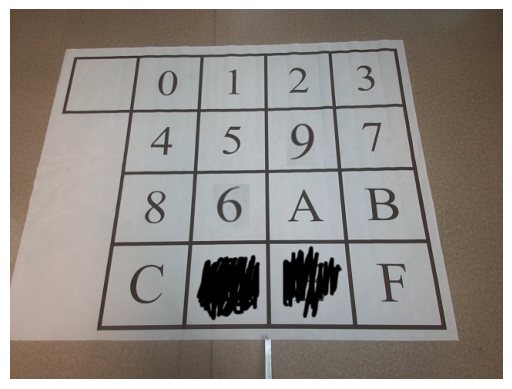

In [55]:
image=cv2.imread('blackDEchange.jpg')
show_image(image)

In [57]:
grid_change_str=['N']*16
grid_change_int=[16]*16
grid_str_int={'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'A':10,'B':11,'C':12,'D':13,'E':14,'F':15,'N':16}
image_tra=image_trans(image)
for i in range(16):
    x=int(i/4)*242
    y=int(i%4)*242
    pi=image_tra[x+20:x+222,y+20:y+222].astype(np.uint8)
    pi3=np.zeros((202,202,3),dtype=np.uint8)
    pi3[:,:,0]=pi
    pi3[:,:,1]=pi
    pi3[:,:,2]=pi
    _,num=get_photo_number(pi3)
    try:
        grid_change_str[i]=num[0]
        grid_change_int[i]=grid_str_int[num[0]]
    except:
        pass
print(grid_change_int)
print(grid_change_str)

[((104.5, 98.0), '0', 0.9596251431720623)]
[((105.0, 102.0), '1', 0.962478177957766)]
[((97.0, 103.5), '2', 0.9813891938033237)]
[((93.5, 99.0), '3', 0.9817496083821002)]
[((106.5, 97.5), '4', 0.9841628078983986)]
[((105.0, 99.5), '5', 0.9810507729427093)]
[((99.0, 107.0), '9', 0.9729650596704937)]
[((95.0, 98.0), '7', 0.9720982770808434)]
[((107.0, 97.5), '8', 0.9819748887666832)]
[((102.0, 90.0), '6', 0.9728473404970331)]
[((98.0, 100.0), 'A', 0.9906952831102909)]
[((96.0, 97.0), 'B', 0.9758198769484391)]
[((104.5, 96.0), 'C', 0.9561789203876173)]
[]
[]
[((99.0, 97.0), 'F', 0.9781953148972701)]
[0, 1, 2, 3, 4, 5, 9, 7, 8, 6, 10, 11, 12, 16, 16, 15]
['0', '1', '2', '3', '4', '5', '9', '7', '8', '6', 'A', 'B', 'C', 'N', 'N', 'F']


In [ ]:
# i决定pi，决定p_char
i=9
x=int(i/4)*242
y=int(i%4)*242
pi=image_tra[x+20:x+222,y+20:y+222]
np.sum(np.abs(pi-p_char[0]))

In [ ]:
cv2.matchTemplate(pi, p_char[6], cv2.TM_CCOEFF_NORMED)

In [ ]:
show_image(pi)

In [ ]:
show_image(p_char[6])


In [ ]:
show_image(image_tra)

In [ ]:
p_ok=cv2.imread('good_trans.jpg')
p_ok=cv2.cvtColor(p_ok, cv2.COLOR_BGR2GRAY)
_,p_ok=cv2.threshold(p_ok, 127, 255, cv2.THRESH_BINARY)
for i in range(16):
    x=int(i/4)*242
    y=int(i%4)*242
    str_i=p_ok[x+20:x+222,y+20:y+222]
    cv2.imwrite(str(i)+'.jpg',str_i)

In [ ]:
image_tra=image_trans(image)
s=1
for j in range(1,31):
    image=cv2.imread(f'{j}.jpg')
    image_tra=image_trans(image)
    for i in range(16):
        x=int(i/4)*242
        y=int(i%4)*242
        pi=image_tra[x+20:x+222,y+20:y+222]
        cv2.imwrite(f'photo\{s}.jpg',pi)
        s+=1